In [20]:
from generate_data import wave_util
from generate_data import wave_propagation
import torch
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from models import model_end_to_end, model_unet
from generate_data.wave_util import WaveEnergyComponentField_tensor

In [ ]:
''''
metrics to compare:
- speed in ms per delta t timestep (fine solver vs end to end) -> scale that to big resolution and say we save x amount of time
- MSE, MAE for each snapshot
- generalization (marmousi and bp dataset, but then own, easier velocities)
'''

In [ ]:
#TODO: change to torch, add other models, add mse mae, and so on

In [32]:
#params
boundary_c = 'absorbing'
dx = 2.0/128.0
dt = dx/20
dX = dx * 2
dT = dt * 4
delta_t_star = .07
T = .7
scaler = 2
np.random.seed = 21
n_snaps = 10
Nx,Ny = 128, 128

In [33]:
# set up models

restr_model1 = model_end_to_end.Restriction_nn(res_scaler=scaler,boundary_c=boundary_c).double()
# restr_model1 = torch.nn.DataParallel(restr_model1)
restr_model1.load_state_dict(torch.load('../results/run_2/saved_model_end_to_end_unet128_5.pt'))
restr_model1.eval()

unet_model2 = model_unet.UNet(depth=3, wf=1, acti_func='relu', scale_factor=2).double()
unet_model2 = torch.nn.DataParallel(unet_model2)
unet_model2.load_state_dict(torch.load('../results/run_1/saved_model_unet3_64_128_9.pt'))
unet_model2.eval()

netlist = [
    (r'end-to-end unet 3lvl', restr_model1),
    (r'unet 3lvl', unet_model2)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

end-to-end unet 3lvl number of trainable parameters 44883
unet 3lvl number of trainable parameters 40008


In [37]:
# velocity and initial pulse

x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

center = np.array([0.,0.])
# center_1 = np.array([-0.8,-0.8])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
# center_2 = np.array([.8,.8])
# u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
# u0 = u0_1 + u0_2
u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([Nx,Ny])
vel = 1. + 0.0*yy #- 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) # #fig9 velnp.ones([Nx,Ny]) #

In [38]:
# propagation

# fine solution
uf = np.zeros([Nx,Ny,n_snaps])
utf = np.zeros([Nx,Ny,n_snaps])
uf[:,:,0] = u0
utf[:,:,0] = ut0
for j in range(1,n_snaps):
    uf[:,:,j],utf[:,:,j] = wave_propagation.velocity_verlet(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,delta_t_star)
#
# # coarse
# ucc = np.zeros([Nx,xx.shape[1],n_snaps])
# utcc = np.zeros([Nx,xx.shape[1],n_snaps])
# ucc[:,:,0] = u0
# utcc[:,:,0] = ut0
# uc = resize(ucc[:,:,0],[Nx,Ny],order=4)
# utc = resize(utcc[:,:,0],[Nx,Ny],order=4)
# velc = resize(vel,[Nx,Ny],order=4)
# for j in range(1,n_snaps):
#     uc, utc = wave_propagation.velocity_verlet(uc,utc,velc,dX,dT,delta_t_star)
#     ucc[:,:,j] = resize(uc,[Nx,Ny],order=4)
#     utcc[:,:,j] = resize(utc,[Nx,Ny],order=4)

# unet_model2

# unn2 = torch.zeros([Nx,Ny,n_snaps])
# utnn2 = torch.zeros([Nx,Ny,n_snaps])
# unn2[:,:,0] = u0
# utnn2[:,:,0] = ut0
# for j in range(1,n_snaps):
#     a,b,c = WaveEnergyComponentField_tensor(unn2[:,:,j-1].unsqueeze(dim=0),utnn2[:,:,j-1].unsqueeze(dim=0),vel.unsqueeze(dim=0), dx)
#     res = restr_model1(torch.stack((a.double(),b.double(),c.double(),vel.unsqueeze(dim=0).double()),dim=1))
#     unn2[:,:,j],utnn2[:,:,j] = res[0,0,:,:], res[0,1,:,:]

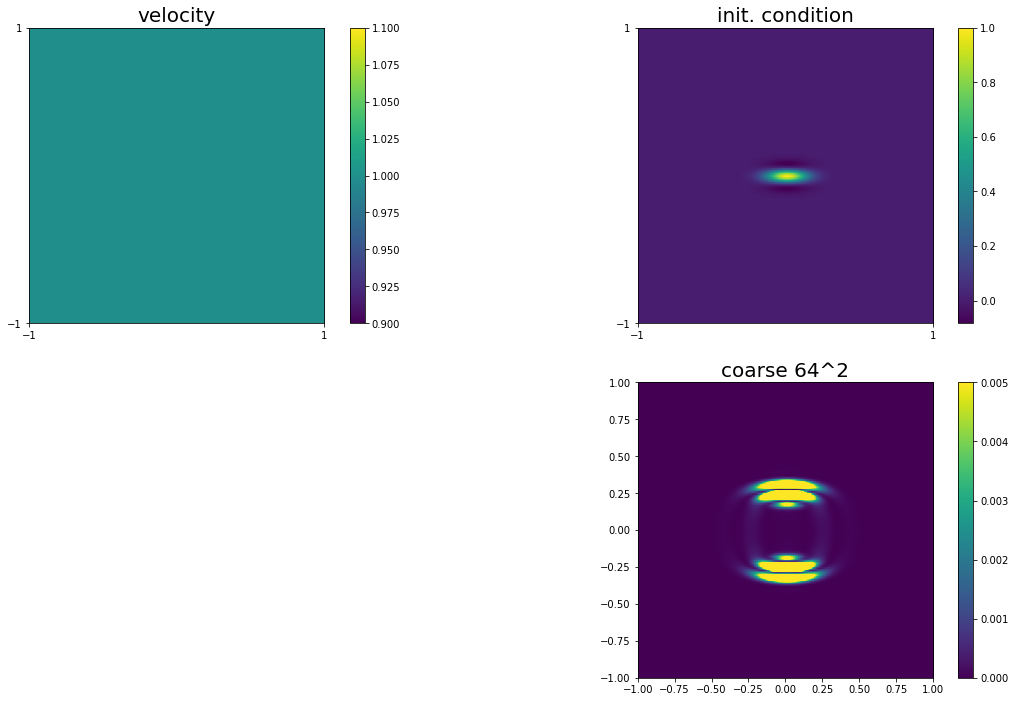

In [39]:
tj = 4
fig1 = plt.figure(figsize=(20,25))
scaler = 50

ax1 = fig1.add_subplot(4,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(4,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

# ax3 = fig1.add_subplot(4,2,3)
# pos3 = ax3.imshow(wave_util.WaveEnergyField(unn2[:,:,tj].detach().numpy(),unn2[:,:,tj].detach().numpy(),vel.detach().numpy(),dx)*dx*dx)
# ax3.set_title('fine 128^2', fontsize=20)
# plt.colorbar(pos1)#,ticks = [0,0.002,0.005])

#
ax4 = fig1.add_subplot(4,2,4)
pos4 = ax4.imshow(wave_util.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax4.set_title('coarse 64^2', fontsize=20)
plt.colorbar(pos4)#,ticks = [0,0.002,0.005])
#
# ax5 = fig1.add_subplot(4,2,5)
# pos5 = ax5.imshow(wave_util.WaveEnergyField(unn1[tj,:,:],utnn1[tj,:,:],vel,dx)*dx*dx*scaler,vmax=.005,extent=(-1,1,-1,1))
# ax5.set_title(r'unet 3lvl $\Delta t^*=0.2$', fontsize=20)
# plt.xticks([-1,1])
# plt.yticks([-1,1])
# plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
# plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
# plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
# plt.colorbar(pos5,ticks = [0,0.002,0.005])
#
# ax6 = fig1.add_subplot(4,2,6)
# pos6 = ax6.imshow(wave_util.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx*scaler,vmax=0.005,extent=(-1,1,-1,1))
# ax6.set_title(r'unet 6lvl $\Delta t^*=0.2$', fontsize=20)
# plt.xticks([-1,1])
# plt.yticks([-1,1])
# plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
# plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
# plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
# plt.colorbar(pos6, ticks = [0,0.002,0.005])

In [ ]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

table = [["snapshot", "MSE unet3", "MSE unet6", "MSE tiramisu", "MSE u_transform"]]
# table = [["snapshot", "MAE unet3", "MAE unet6", "MAE tiramisu", "MAE u_transform"]]

for it in range(1,10):
    wf = wave_util.WaveEnergyField(uf[:,:,it], utf[:,:,it], vel, dx)*dx*dx
    w1 = wave_util.WaveEnergyField(unn1[it,:,:], utnn1[it,:,:], vel, dx)*dx*dx
    w2 = wave_util.WaveEnergyField(unn2[:,:,it], utnn2[:,:,it], vel, dx)*dx*dx

    # mae1 = mean_absolute_error(wf, w1)
    # mae2 = mean_absolute_error(wf, w2)
    # mae3 = mean_absolute_error(wf, w3)
    # mae4 = mean_absolute_error(wf, w4)

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    table.append([it, mse1, mse2])
    #table.append([it, mae1, mae2, mae3, mae4])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))